In [1]:
import bz2
import json
import io
import ipaddress
import logging

import pandas as pd
import pytricia
import requests

from typing import Generator, NamedTuple, Optional, Set

from pandas.api.types import CategoricalDtype
from pandas.core.series import Series

LOG = logging.getLogger(__name__)
LOG.setLevel(logging.DEBUG)

In [2]:
class RouteOriginAuthorization(NamedTuple):
    asn: int
    prefix: str
    max_length: int

    prefix_length: Optional[int] = None
        
class ExpandedRisEntry(NamedTuple):
    origin: str
    prefix: str
    seen_by_peers: int
    prefix_length: int
    roa_validity: str

In [3]:
# https://www.ris.ripe.net/dumps/riswhoisdump.IPv4.gz
# https://www.ris.ripe.net/dumps/riswhoisdump.IPv6.gz
ris_v4_gz = requests.get("https://www.ris.ripe.net/dumps/riswhoisdump.IPv4.gz").content
ris_v6_gz = requests.get("https://www.ris.ripe.net/dumps/riswhoisdump.IPv6.gz").content

def read_ris_dump(url: str) -> pd.DataFrame:
    # Get file, accept that there are comment lines in there
    df = pd.read_csv(url,
                     compression='gzip',
                     sep="\t",
                     names=["origin", "prefix", "seen_by_peers"]
    )
    
    if df.origin.str.startswith('{').any():
        LOG.error("RIS dump contains row(s) with AS_SET! These will never be RPKI valid (https://tools.ietf.org/html/rfc6907#section-7.1.8)")
    # select the rows that do not have the '%' prefix
    df = df[~df.origin.str.startswith('%')].copy()
    
    # separate prefix length
    df['prefix_length'] = df.prefix.map(lambda p: ipaddress.ip_network(p).prefixlen)
    
    return df

In [4]:
# Atlas Probe archive
atlas_probes_bz2 = requests.get("https://ftp.ripe.net/ripe/atlas/probes/archive/meta-latest").content
atlas_probes = pd.DataFrame(json.loads(bz2.decompress(atlas_probes_bz2))['objects'])

In [5]:
ris_v4 = read_ris_dump("https://www.ris.ripe.net/dumps/riswhoisdump.IPv4.gz")
ris_v6 = read_ris_dump("https://www.ris.ripe.net/dumps/riswhoisdump.IPv6.gz")

RIS dump contains row(s) with AS_SET! These will never be RPKI valid (https://tools.ietf.org/html/rfc6907#section-7.1.8)
RIS dump contains row(s) with AS_SET! These will never be RPKI valid (https://tools.ietf.org/html/rfc6907#section-7.1.8)


In [6]:
# Get RPKI valids
validated_objects = requests.get("https://rpki-validator.ripe.net/api/objects/validated").json()
rpki_roas = pd.DataFrame(validated_objects['data']['roas'])
# And add address family
rpki_roas['af'] = af = rpki_roas.prefix.map(lambda p: ipaddress.ip_network(p).version)
# And prefix length (to chart later)
rpki_roas['prefix_length'] = af = rpki_roas.prefix.map(lambda p: ipaddress.ip_network(p).prefixlen)

In [7]:
rpki_roas_v4 = rpki_roas[rpki_roas.af == 4]
rpki_roas_v6 = rpki_roas[rpki_roas.af == 6]

In [8]:
class RouteOriginAuthorizationLookup:
    """
    Build patricia tries for storing ROAs.

    The entries of the patricia tries will be a set of RouteOriginAuthorization that are an
    exact match for the prefix of a key.

    To lookup all applicable ROAs for a value, first retrieve the most specific entry,
    followed by looking up the parents.
    """
    trie: pytricia.PyTricia
        
    def __init__(self, data: pd.DataFrame) -> None:
        assert data.af.nunique() == 1
        length = 128 if data.af.unique()[0] == 6 else 32
        
        self.trie = pytricia.PyTricia(length)
        data.apply(self.__build_trie, axis=1)
        
    def __build_trie(self, row: Series) -> None:
        if not self.trie.has_key(row.prefix):
            # Add entry
            self.trie[row.prefix] = set()
            
        self.trie[row.prefix].add(
            RouteOriginAuthorization(row.asn, row.prefix, row.maxLength, row.prefix_length)
        )
        
    def __getitem__(self, prefix) -> Set[RouteOriginAuthorization]:
        return set(self.lookup(prefix))
    
    def lookup(self, prefix) -> Generator[RouteOriginAuthorization, None, None]:
        key = self.trie.get_key(prefix)
        while key is not None:
            yield from self.trie[key]
            key = self.trie.parent(key)
        
roa_lookup_v4 = RouteOriginAuthorizationLookup(rpki_roas_v4)
roa_lookup_v6 = RouteOriginAuthorizationLookup(rpki_roas_v6)

In [9]:
# This prefix has a ROA for a less specific
roa_lookup_v4['1.6.108.0/24']

{RouteOriginAuthorization(asn='9583', prefix='1.6.108.0/22', max_length=22, prefix_length=22),
 RouteOriginAuthorization(asn='9583', prefix='1.6.108.0/24', max_length=24, prefix_length=24)}

### Data has been loaded

Spot-check a sample from the roas in the prefix tries for both address families. Filter so it is a sample not from the most-common prefix length.

Starting with IPv4:

In [10]:
rpki_roas_v4.describe()

,maxLength,af,prefix_length
count,188493.000000,188493.0,188493.000000
mean,23.273145,4.0,22.617874
std,2.112517,0.0,2.250268
min,10.000000,4.0,9.000000
25%,23.000000,4.0,22.000000
50%,24.000000,4.0,24.000000
75%,24.000000,4.0,24.000000
max,32.000000,4.0,32.000000


In [11]:
sample = rpki_roas_v4[rpki_roas_v4.prefix_length != 24].sample(5).reset_index()
display(sample)

,index,asn,prefix,maxLength,af,prefix_length
0,152994,34602,77.50.16.0/20,20,4,20
1,136094,19905,89.43.172.0/23,24,4,23
2,151016,33915,212.203.0.0/20,20,4,20
3,3992,4755,121.244.134.0/23,23,4,23
4,95853,28343,138.97.136.0/22,24,4,22


In [12]:
roa_lookup_v4.trie[sample.prefix[0]]

{RouteOriginAuthorization(asn='34602', prefix='77.50.16.0/20', max_length=20, prefix_length=20)}

The printed entry should match the `prefix_length` in the top row of the table.

<AxesSubplot:ylabel='Frequency'>

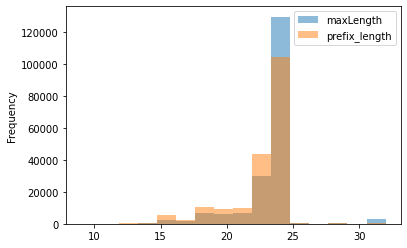

In [13]:
rpki_roas_v4[['maxLength', 'prefix_length']].plot.hist(
    by='maxLength',
    bins=16,
    alpha=0.5
)

And now IPv6, again skipping what is likely the most common prefix_length

In [14]:
rpki_roas_v6.describe()

,maxLength,af,prefix_length
count,31455.000000,31455.0,31455.000000
mean,43.772945,6.0,41.157018
std,10.802325,0.0,8.443472
min,19.000000,6.0,19.000000
25%,36.000000,6.0,32.000000
50%,48.000000,6.0,44.000000
75%,48.000000,6.0,48.000000
max,128.000000,6.0,128.000000


In [15]:
sample = rpki_roas_v6[rpki_roas_v6.prefix_length != 48].sample(5).reset_index()
display(sample)

,index,asn,prefix,maxLength,af,prefix_length
0,96867,52436,2803:b900::/32,32,6,32
1,5277,4775,2001:fe0:1111:20::/59,59,6,59
2,187385,57045,2a0e:1106:1000::/40,48,6,40
3,134037,15965,2a02:3a8::/32,32,6,32
4,101108,266768,2803:4f20::/32,64,6,32


In [16]:
roa_lookup_v6.trie[sample.prefix[0]]

{RouteOriginAuthorization(asn='52436', prefix='2803:b900::/32', max_length=32, prefix_length=32)}

<AxesSubplot:ylabel='Frequency'>

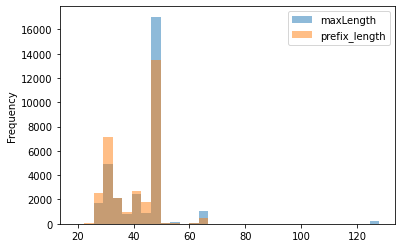

In [17]:
rpki_roas_v6[['maxLength', 'prefix_length']].plot.hist(
    by='maxLength',
    bins=32,
    alpha=0.5
)

All data has been collected.

In [18]:
ris_v4

,origin,prefix,seen_by_peers,prefix_length
16,174,0.0.0.0/0,5.0,0
17,55720,0.0.0.0/0,2.0,0
18,30823,0.0.0.0/0,1.0,0
19,3356,0.0.0.0/0,2.0,0
20,50628,0.0.0.0/0,2.0,0
...,...,...,...,...
992679,63199,223.255.250.0/24,324.0,24
992680,63199,223.255.251.0/24,324.0,24
992681,58519,223.255.252.0/24,327.0,24
992682,58519,223.255.253.0/24,327.0,24


In [19]:
def roa_validity(ris_entry: Series, lookup: RouteOriginAuthorizationLookup) -> str:
    """
    Determine ROA validation outcome for an entry.
    
    Algorithm from `RFC6483 section 2 <https://tools.ietf.org/html/rfc6483#section-2>`_.
    """
    # A route validity state is defined by the following procedure:
    #
    # 1. Select all valid ROAs that include a ROAIPAddress value that
    #    either matches, or is a covering aggregate of, the address
    #    prefix in the route.  This selection forms the set of
    #    "candidate ROAs".
    roa = None
    for roa in lookup.lookup(ris_entry.prefix):
        # 3. If the route's origin AS can be determined and any of the set
        #    of candidate ROAs has an asID value that matches the origin AS
        #    in the route, and
        if roa.asn == ris_entry.origin:
            # the route's address prefix matches a
            #    ROAIPAddress in the ROA (where "match" is defined as where the
            #    route's address precisely matches the ROAIPAddress, or where
            #    the ROAIPAddress includes a maxLength element, and the route's
            #    address prefix is a more specific prefix of the ROAIPAddress,
            #    and the route's address prefix length value is less than or
            #    equal to the ROAIPAddress maxLength value), then the procedure
            #    halts with an outcome of "valid".
            if roa.max_length and roa.max_length >= ris_entry.prefix_length:
                return "valid"
    if roa:
        # 4. Otherwise, the procedure halts with an outcome of "invalid".
        return 'invalid'
    else:
        # 2. If the set of candidate ROAs is empty, then the procedure stops
        #    with an outcome of "unknown" (or, synonymously, "not found", as
        #    used in [BGP-PFX]).
        return 'unknown'

def roa_validity_verbose(ris_entry: Series, lookup: RouteOriginAuthorizationLookup) -> str:
    # Match roas, to match, they need to:
    # * have the same AS as the ROA
    # * have a prefix length <= maxLength
    roas = lookup[series.origin]
    if not roas:
        return 'unknown'
    was_valid = False
    for roa in roas:
        print(roa)
        if roa.asn != ris_entry.origin:
            LOG.info("invalid as: %s ris origin: %d for %s", roa, ris_entry.origin, ris_entry.prefix)
        else:
            assert roa.prefix_length <= ris_entry.prefix_length
            if roa.max_length >= ris_entry.prefix_length:
                LOG.info("valid roa: %s for %s announced by %s", roa, ris_entry.prefix, ris_entry.origin)
                was_valid = True
            else:
                LOG.info("invalid length: %s does not match %s", ris_entry.prefix)
        
    return 'valid' if was_valid else 'invalid'

ris_v4.sample(1).apply(lambda x: roa_validity(x, roa_lookup_v4), axis=1)

912672    unknown
dtype: object

In [23]:
ris_v4['roa_validity'] = ris_v4.apply(lambda x: roa_validity(x, roa_lookup_v4), axis=1)
ris_v6['roa_validity'] = ris_v6.apply(lambda x: roa_validity(x, roa_lookup_v6), axis=1)


In [24]:
class RisWhoisLookup:
    trie: pytricia.PyTricia
        
    def __init__(self, data: pd.DataFrame, visibility_threshold : int = 10) -> None:
        af = data.prefix.apply(lambda p: ipaddress.ip_network(p).version)
        assert af.nunique() == 1
        length = 128 if af.unique()[0] == 6 else 32
        
        self.trie = pytricia.PyTricia(length)
        data[data.seen_by_peers >= visibility_threshold].apply(self.__build_trie, axis=1)
        
    def __build_trie(self, row: Series) -> None:
        if not self.trie.has_key(row.prefix):
            # Add entry
            self.trie[row.prefix] = set()
            
        self.trie[row.prefix].add(
            ExpandedRisEntry(row.origin, row.prefix, row.seen_by_peers, row.prefix_length, row.roa_validity)
        )
       
    def lookup(self, prefix) -> Generator[ExpandedRisEntry, None, None]:
        key = self.trie.get_key(prefix)
        while key is not None:
            yield from self.trie[key]
            key = self.trie.parent(key)
            
    def __getitem__(self, prefix) -> Set[ExpandedRisEntry]:
        return set(self.lookup(prefix))

In [25]:
# And build patricia trie
ris_v4_lookup = RisWhoisLookup(ris_v4)
ris_v6_lookup = RisWhoisLookup(ris_v6)

In [26]:
ris_v4[ris_v4.roa_validity == "unknown"].sample(20)

,origin,prefix,seen_by_peers,prefix_length,roa_validity
440619,133024,122.128.106.0/24,5.0,24,unknown
976103,139007,218.21.252.0/23,327.0,23,unknown
709784,3269,188.10.0.0/16,338.0,16,unknown
213524,203523,77.81.109.0/24,347.0,24,unknown
381235,20057,107.85.172.0/22,330.0,22,unknown
539043,3379,162.119.16.0/22,331.0,22,unknown
933747,17506,210.79.0.0/20,339.0,20,unknown
352384,138388,103.124.97.0/24,340.0,24,unknown
541523,3295,162.246.247.0/24,336.0,24,unknown
285609,49998,91.213.107.0/24,334.0,24,unknown


In [27]:
# Take the RPKI smiley range, from https://sg-pub.ripe.net/jasper/rpki-web-test/
# and lookup what it is announced by
# e.g. `whois -h riswhois.ripe.net 209.24.0.3`
# the announcement is for 209.24.0.0/24
display(ris_v4[(ris_v4.roa_validity == "invalid") & (ris_v4.prefix == '209.24.0.0/24')])
# or:
ris_v4_lookup['209.24.0.3']

,origin,prefix,seen_by_peers,prefix_length,roa_validity
923891,15562,209.24.0.0/24,211.0,24,invalid


{ExpandedRisEntry(origin='15562', prefix='209.24.0.0/24', seen_by_peers=211.0, prefix_length=24, roa_validity='invalid')}

In [28]:
def is_in_valid_v4(prefix: str):
    if not prefix:
        return None
    was_unknown = False
    
    for route in ris_v4_lookup[prefix]:
        if route.roa_validity == 'valid':
            return "valid"
        if route.roa_validity == 'unknown':
            was_unknown = True
            
    return "unknown" if was_unknown else "invalid"

def is_in_valid_v6(prefix: str):
    if not prefix:
        return None
    was_unknown = False
    
    for route in ris_v6_lookup[prefix]:
        if route.roa_validity == 'valid':
            return "valid"
        if route.roa_validity == 'unknown':
            was_unknown = True
            
    return "unknown" if was_unknown else "invalid"



In [31]:
# Invalid
display(is_in_valid_v4("209.24.0.3"))
# valid
display(is_in_valid_v4("193.0.1.6"))
# Unknown
display(is_in_valid_v4("138.204.43.1"))

'invalid'

'valid'

'unknown'

In [32]:
atlas_probes['address_v4_rov'] = atlas_probes.address_v4.map(is_in_valid_v4)
atlas_probes['address_v6_rov'] = atlas_probes.address_v6.map(is_in_valid_v6)

In [33]:
atlas_probes[(atlas_probes.address_v4_rov == 'invalid')]

,id,address_v4,address_v6,asn_v4,asn_v6,prefix_v4,prefix_v6,is_anchor,is_public,status,...,total_uptime,tags,country_code,latitude,longitude,day,probe,status_name,address_v4_rov,address_v6_rov
215,1000252,185.213.164.4,2a05:1a10:2001:7::4,61173.0,43754.0,185.213.164.0/24,2a05:1a10:2001::/48,False,True,3,...,18458609,"[ipv4, ipv6, system-software, system-ipv6-capa...",IR,35.7385,51.3795,20210220,https://atlas.ripe.net/api/v2/probes/1000252/,Abandoned,invalid,valid
2451,10802,46.226.154.100,None,197541.0,NaN,46.226.154.0/24,None,False,True,3,...,31341,"[system-ipv4-capable, system-v3, multihomed, i...",SE,59.2585,18.0975,20210220,https://atlas.ripe.net/api/v2/probes/10802/,Abandoned,invalid,None
2726,11084,91.233.212.9,None,199067.0,NaN,91.233.212.0/24,None,False,True,3,...,85953979,"[system-ipv4-capable, system-v3, no-nat]",RU,55.7795,49.1315,20210220,https://atlas.ripe.net/api/v2/probes/11084/,Abandoned,invalid,None
2872,11235,168.243.172.197,None,27750.0,NaN,168.243.172.0/22,None,False,True,3,...,68150956,"[system-ipv4-rfc1918, system-ipv4-capable, sys...",SV,13.6995,-89.2215,20210220,https://atlas.ripe.net/api/v2/probes/11235/,Abandoned,invalid,None
3051,11435,185.5.129.246,None,61426.0,NaN,185.5.129.0/24,None,False,True,3,...,17514152,"[system-flash-drive-filesystem-corrupted, syst...",RU,45.0595,41.9985,20210220,https://atlas.ripe.net/api/v2/probes/11435/,Abandoned,invalid,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32527,6285,72.21.93.35,2606:2800:4220:c::a,15133.0,15133.0,72.21.93.0/24,2606:2800:4220::/47,True,True,3,...,57591611,"[system-v2-soekris, system-ipv6-capable, syste...",US,33.7495,-84.3885,20210220,https://atlas.ripe.net/api/v2/probes/6285/,Abandoned,invalid,invalid
32965,6682,45.90.160.13,2a0d:ef00:0:7::12,35395.0,35395.0,45.90.160.0/24,2a0d:ef00::/48,True,True,3,...,25498564,"[system-dns-problem-suspected, system-virtual,...",BE,50.8485,4.3515,20210220,https://atlas.ripe.net/api/v2/probes/6682/,Abandoned,invalid,invalid
32975,6691,185.17.8.54,2a06:1301:4020:1048:185:17:8:54,51907.0,51907.0,185.17.8.0/24,2a06:1301:4020::/48,True,True,2,...,37087031,"[system-dns-problem-suspected, system-ipv4-sta...",RU,55.0175,82.9315,20210220,https://atlas.ripe.net/api/v2/probes/6691/,Disconnected,invalid,invalid
33205,690,193.162.32.222,2001:6c8:100:1500:220:4aff:fec5:5b06,3292.0,3292.0,193.162.32.0/23,2001:6c8::/29,False,True,3,...,253651574,"[system-no-controller-connection, system-ipv4-...",DK,56.2275,10.2315,20210220,https://atlas.ripe.net/api/v2/probes/690/,Abandoned,invalid,valid


In [43]:
active_probes_v4_or_v6_invalid = atlas_probes[((atlas_probes.address_v4_rov == 'invalid') | (atlas_probes.address_v6_rov == 'invalid')) & (atlas_probes.status_name != 'Abandoned')]

In [44]:
active_probes_v4_or_v6_invalid.sample(5)

,id,address_v4,address_v6,asn_v4,asn_v6,prefix_v4,prefix_v6,is_anchor,is_public,status,...,total_uptime,tags,country_code,latitude,longitude,day,probe,status_name,address_v4_rov,address_v6_rov
24579,34615,81.133.171.13,fdaa:bbcc:ddee:0:c225:e9ff:fe9a:13ca,2856.0,NaN,81.128.0.0/12,None,False,True,1,...,13496780,"[system-ipv4-stable-1d, system-resolves-aaaa-c...",GB,51.5595,0.0775,20210220,https://atlas.ripe.net/api/v2/probes/34615/,Connected,unknown,invalid
19328,29203,91.137.89.84,fd00::a62b:b0ff:fee0:bc8,198726.0,NaN,91.137.88.0/21,None,False,True,1,...,131344978,"[system-ipv6-ula, system-ipv6-capable, system-...",DE,48.3585,11.2575,20210220,https://atlas.ripe.net/api/v2/probes/29203/,Connected,unknown,invalid
16574,26290,91.224.157.51,fd98:eb5d:16d0:0:c66e:1fff:fe5b:e188,51124.0,NaN,91.224.157.0/24,None,False,True,1,...,62968482,"[system-resolves-aaaa-correctly, system-ipv4-r...",UA,50.4375,30.4815,20210220,https://atlas.ripe.net/api/v2/probes/26290/,Connected,unknown,invalid
32968,6685,185.174.157.222,2a0d:82c2:0:2::2,203020.0,NaN,185.174.157.0/24,None,True,True,1,...,37727364,"[system-resolves-aaaa-correctly, system-resolv...",US,37.5495,-121.9885,20210220,https://atlas.ripe.net/api/v2/probes/6685/,Connected,unknown,invalid
9915,19093,89.249.248.146,2a01:94c0:0:100:c24a:ff:fecc:6856,31370.0,NaN,89.249.240.0/20,None,False,True,1,...,176817324,"[system-resolves-aaaa-correctly, system-resolv...",RU,55.6285,37.4415,20210220,https://atlas.ripe.net/api/v2/probes/19093/,Connected,unknown,invalid


In [45]:
atlas_probes[((atlas_probes.address_v4_rov == 'invalid')) & (atlas_probes.status_name != 'Abandoned')]

,id,address_v4,address_v6,asn_v4,asn_v6,prefix_v4,prefix_v6,is_anchor,is_public,status,...,total_uptime,tags,country_code,latitude,longitude,day,probe,status_name,address_v4_rov,address_v6_rov
32975,6691,185.17.8.54,2a06:1301:4020:1048:185:17:8:54,51907.0,51907.0,185.17.8.0/24,2a06:1301:4020::/48,True,True,2,...,37087031,"[system-dns-problem-suspected, system-ipv4-sta...",RU,55.0175,82.9315,20210220,https://atlas.ripe.net/api/v2/probes/6691/,Disconnected,invalid,invalid
